In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

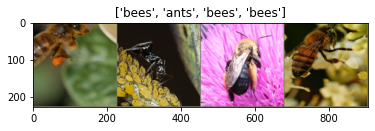

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model,criterion,optimizer,scheduler,num_epochs=25):
    since = time.time()
    # keeping track of best weights and best accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Iterating through dataset
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)
        
        # Going through both training and validation phases
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            # Loss and number of corrects for each epoch
            running_loss = 0.0
            running_corrects = 0
            
            # Iterating over the data
            for inputs,labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zeroing out parameter gradients
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            # calculating loss and accuracy for current epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
# Loading in resnet pretrained model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs,2)

# Output layer of 2 neurons
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
# All params are being optmized
optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001,momentum=0.9)

# Decaying learning rate by 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)

In [7]:
# Training 
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5000 Acc: 0.7254
val Loss: 0.2662 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.5919 Acc: 0.7582
val Loss: 0.2269 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4742 Acc: 0.8156
val Loss: 0.2726 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.6515 Acc: 0.7541
val Loss: 0.4031 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.4602 Acc: 0.8156
val Loss: 0.3947 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.4308 Acc: 0.8156
val Loss: 0.2362 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.4834 Acc: 0.8033
val Loss: 0.5491 Acc: 0.7778

Epoch 7/24
----------
train Loss: 0.4159 Acc: 0.8156
val Loss: 0.2221 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2585 Acc: 0.9016
val Loss: 0.2306 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3221 Acc: 0.8525
val Loss: 0.2371 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3142 Acc: 0.8730
val Loss: 0.2150 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2969 Acc: 0.8934
val Loss: 0.2193 Acc: 0.9085

Ep

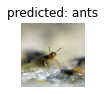

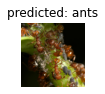

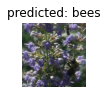

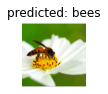

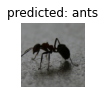

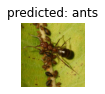

In [9]:
visualize_model(model_ft)

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7239 Acc: 0.5943
val Loss: 0.2254 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.6070 Acc: 0.7336
val Loss: 0.3771 Acc: 0.8170

Epoch 2/24
----------
train Loss: 0.4945 Acc: 0.7828
val Loss: 0.2289 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4279 Acc: 0.8197
val Loss: 0.1993 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.4523 Acc: 0.7910
val Loss: 0.2202 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4572 Acc: 0.7828
val Loss: 0.3116 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.5889 Acc: 0.7500
val Loss: 0.1973 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.3068 Acc: 0.8689
val Loss: 0.2285 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3511 Acc: 0.8525
val Loss: 0.1905 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3457 Acc: 0.8320
val Loss: 0.1894 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.3968 Acc: 0.8320
val Loss: 0.1919 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.3791 Acc: 0.8197
val Loss: 0.1967 Acc: 0.9542

Ep

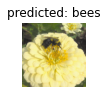

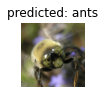

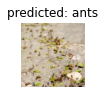

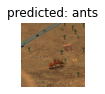

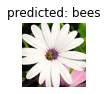

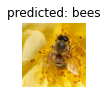

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()